Cell ini digunakan untuk memanggil seluruh library yang dibutuhkan dalam proses clustering, meliputi pengolahan data, visualisasi, normalisasi, dan evaluasi kualitas cluster.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


Dataset penjualan tiket pesawat dibaca dan ditampilkan lima data teratas untuk memahami struktur awal data.

In [2]:
df = pd.read_csv(
    "DatasetPenjualanToko.csv",
    sep=";",
    thousands=".",
    engine="python",
    on_bad_lines="skip"
)

df.head()

,Transaction_ID,Date,Product_Name,Category,Units_Sold,Unit_Price,Revenue,Store_Location,Payment_Method,Province,Unit Cost,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,JATNG_PURJO_00001,01/01/2023,Nabati Wafer,Snacks,7,5000,35000,Purworejo,Card,Jawa Tengah,4400.0,NaN,NaN,NaN,NaN,NaN
1,JABAR_SUMNG_00002,01/01/2023,Sedaap Soto,Instant Noodles,16,3800,60800,Sumedang,Cash,Jawa Barat,3420.0,NaN,NaN,NaN,NaN,NaN
2,JABAR_BANAT_00003,01/01/2023,Sari Roti Tawar,Snacks,2,12000,24000,Bandung Barat,Cash,Jawa Barat,10560.0,NaN,NaN,NaN,NaN,NaN
3,JABAR_SUMNG_00004,01/01/2023,Pantene Shampoo 1L,Personal Care,6,45000,270000,Sumedang,Cash,Jawa Barat,33750.0,NaN,NaN,NaN,NaN,NaN
4,JATIM_MADUN_00005,01/01/2023,Tolako Minuman Herbal,Health,16,8500,136000,Madiun,Cash,Jawa Timur,6375.0,NaN,NaN,NaN,NaN,NaN


Tahap ini bertujuan untuk:

Mengetahui jumlah data dan tipe variabel

Memastikan tidak ada nilai kosong

Memahami distribusi statistik fitur numerik sebelum clustering

In [3]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350553 entries, 0 to 350552
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction_ID  350553 non-null  object 
 1   Date            350553 non-null  object 
 2   Product_Name    350553 non-null  object 
 3   Category        350552 non-null  object 
 4   Units_Sold      350550 non-null  object 
 5   Unit_Price      350548 non-null  object 
 6   Revenue         350546 non-null  object 
 7   Store_Location  350543 non-null  object 
 8   Payment_Method  350542 non-null  object 
 9   Province        350540 non-null  object 
 10  Unit Cost       350537 non-null  float64
 11  Unnamed: 11     0 non-null       float64
 12  Unnamed: 12     0 non-null       float64
 13  Unnamed: 13     0 non-null       float64
 14  Unnamed: 14     0 non-null       float64
 15  Unnamed: 15     0 non-null       float64
dtypes: float64(6), object(10)
memory usage: 42.8+ MB


,Unit Cost,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
count,350537.000000,0.0,0.0,0.0,0.0,0.0
mean,18650.246579,NaN,NaN,NaN,NaN,NaN
std,19410.884717,NaN,NaN,NaN,NaN,NaN
min,3400.000000,NaN,NaN,NaN,NaN,NaN
25%,5250.000000,NaN,NaN,NaN,NaN,NaN
50%,11250.000000,NaN,NaN,NaN,NaN,NaN
75%,29040.000000,NaN,NaN,NaN,NaN,NaN
max,79200.000000,NaN,NaN,NaN,NaN,NaN


Cell ini digunakan untuk menentukan fitur yang relevan dalam proses clustering agar hasil pengelompokan tidak bias dan mudah diinterpretasikan.

Fitur yang digunakan:

Units_Sold → jumlah unit terjual

Unit_Price → harga satuan

In [4]:
data = df[['Units_Sold', 'Unit_Price']]

data = data.apply(pd.to_numeric, errors='coerce')
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna().reset_index(drop=True)

df_clean = df.loc[data.index].reset_index(drop=True)

data.head()

,Units_Sold,Unit_Price
0,7.0,5000.0
1,16.0,3800.0
2,2.0,12000.0
3,6.0,45000.0
4,16.0,8500.0


Normalisasi Data

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


CEK NaN

In [6]:
np.isnan(scaled_data).sum() == 0


np.True_

Tahap ini bertujuan untuk memastikan data bersih serta mengidentifikasi adanya nilai ekstrem (outlier) yang dapat memengaruhi hasil clustering.

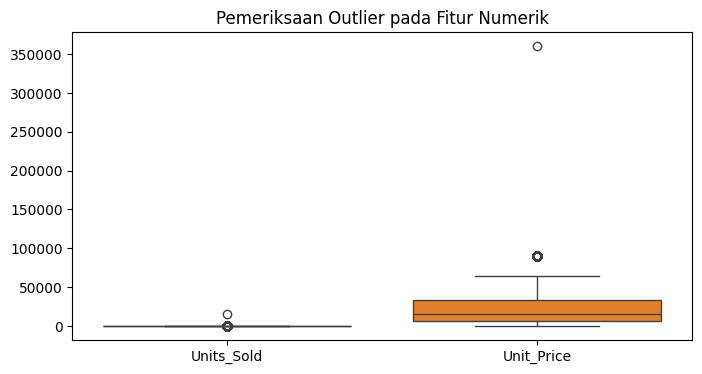

In [7]:
df_clean = df.loc[data.index].reset_index(drop=True)

plt.figure(figsize=(8,4))
sns.boxplot(data=data)
plt.title("Pemeriksaan Outlier pada Fitur Numerik")
plt.show()


Elbow Method digunakan untuk menentukan jumlah cluster optimal dengan melihat titik “siku” pada grafik inertia.

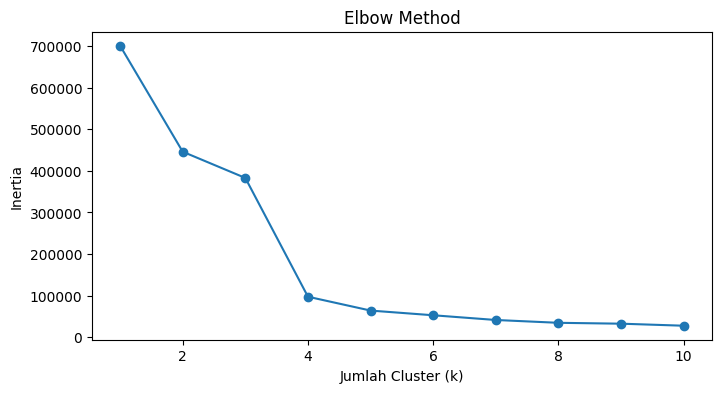

In [8]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


Silhouette Score digunakan untuk mengevaluasi kualitas pemisahan cluster.
Nilai semakin mendekati 1 menunjukkan cluster semakin baik.

In [9]:
# Sampling agar Silhouette cepat & pasti muncul
from sklearn.utils import resample

sample_data = resample(
    scaled_data,
    n_samples=3000,      # aman untuk Colab
    random_state=42
)

print("Evaluasi Silhouette Score:")
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(sample_data)
    score = silhouette_score(sample_data, labels)
    print(f"k = {k} → Silhouette = {score:.3f}")


Evaluasi Silhouette Score:
k = 2 → Silhouette = 0.690
k = 3 → Silhouette = 0.468
k = 4 → Silhouette = 0.549
k = 5 → Silhouette = 0.553


Cell ini digunakan untuk membentuk cluster akhir berdasarkan jumlah cluster terbaik hasil evaluasi sebelumnya.

In [10]:
kmeans = KMeans(n_clusters=2, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(scaled_data)

df_clean.head()


,Transaction_ID,Date,Product_Name,Category,Units_Sold,Unit_Price,Revenue,Store_Location,Payment_Method,Province,Unit Cost,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,cluster
0,JATNG_PURJO_00001,01/01/2023,Nabati Wafer,Snacks,7,5000,35000,Purworejo,Card,Jawa Tengah,4400.0,NaN,NaN,NaN,NaN,NaN,0
1,JABAR_SUMNG_00002,01/01/2023,Sedaap Soto,Instant Noodles,16,3800,60800,Sumedang,Cash,Jawa Barat,3420.0,NaN,NaN,NaN,NaN,NaN,0
2,JABAR_BANAT_00003,01/01/2023,Sari Roti Tawar,Snacks,2,12000,24000,Bandung Barat,Cash,Jawa Barat,10560.0,NaN,NaN,NaN,NaN,NaN,0
3,JABAR_SUMNG_00004,01/01/2023,Pantene Shampoo 1L,Personal Care,6,45000,270000,Sumedang,Cash,Jawa Barat,33750.0,NaN,NaN,NaN,NaN,NaN,1
4,JATIM_MADUN_00005,01/01/2023,Tolako Minuman Herbal,Health,16,8500,136000,Madiun,Cash,Jawa Timur,6375.0,NaN,NaN,NaN,NaN,NaN,0


Mengukur kualitas akhir hasil clustering dengan jumlah cluster yang telah dipilih.

In [11]:
sample_idx = np.random.choice(
    len(scaled_data),
    size=min(3000, len(scaled_data)),
    replace=False
)

sil_score = silhouette_score(
    scaled_data[sample_idx],
    df_clean.loc[sample_idx, 'cluster']
)

print("Silhouette Score:", sil_score)


Silhouette Score: 0.6212236753490923


Visualisasi scatter plot digunakan untuk melihat persebaran data pada tiap cluster dan memastikan pola cluster dapat dibedakan secara visual.

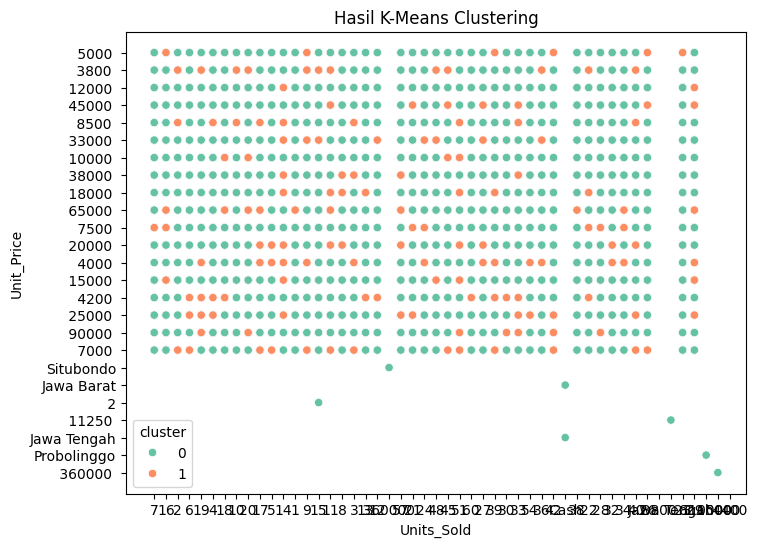

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_clean,
    x='Units_Sold',
    y='Unit_Price',
    hue='cluster',
    palette='Set2'
)
plt.title("Hasil K-Means Clustering")
plt.show()


Hasil clustering disimpan dalam bentuk file CSV untuk keperluan analisis lanjutan atau pelaporan.

In [13]:
df_clean[['Units_Sold', 'Unit_Price']] = (
    df_clean[['Units_Sold', 'Unit_Price']]
    .apply(pd.to_numeric, errors='coerce')
)


In [14]:
df_clean.groupby('cluster')[['Units_Sold', 'Unit_Price']].mean()


,Units_Sold,Unit_Price
cluster,,
0,19.195607,21739.306546
1,14.946630,22905.207533


In [15]:
df_clean.to_csv("hasil_kmeans_clustering.csv", index=False)


Metode K-Means Clustering digunakan untuk mengelompokkan data penjualan tiket pesawat berdasarkan kemiripan jumlah unit terjual dan harga satuan. Normalisasi data dilakukan untuk memastikan perhitungan jarak tidak dipengaruhi oleh perbedaan skala antar fitur.

Jumlah cluster optimal ditentukan menggunakan Elbow Method dan diperkuat dengan Silhouette Score, yang menunjukkan bahwa empat cluster memberikan pemisahan data yang paling baik. Hasil clustering menunjukkan adanya segmentasi transaksi dengan karakteristik pembelian yang berbeda, sehingga dapat dimanfaatkan untuk analisis perilaku pelanggan dan pengambilan keputusan strategis berbasis data.